Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


DQN Evaluation saved
CSV: E:/project\outputs\evaluations\dqn_discrete_equity_test.csv
JSON metrics: E:/project\outputs\evaluations\dqn_discrete_metrics_test.json
PNG plot: E:/project\outputs\plots\dqn_discrete_equity_test.png
Metrics: {'total_return_pct': np.float64(2.4388899999999714), 'CAGR_pct': np.float64(3.355195699111202), 'volatility_ann_pct': np.float64(14.70055886930632), 'sharpe': np.float64(0.22823591270946095), 'max_drawdown_pct': np.float64(-15.477903324112718), 'calmar': np.float64(0.2167732548833636), 'sortino': np.float64(0.3351586516494146), 'n_days': 184}


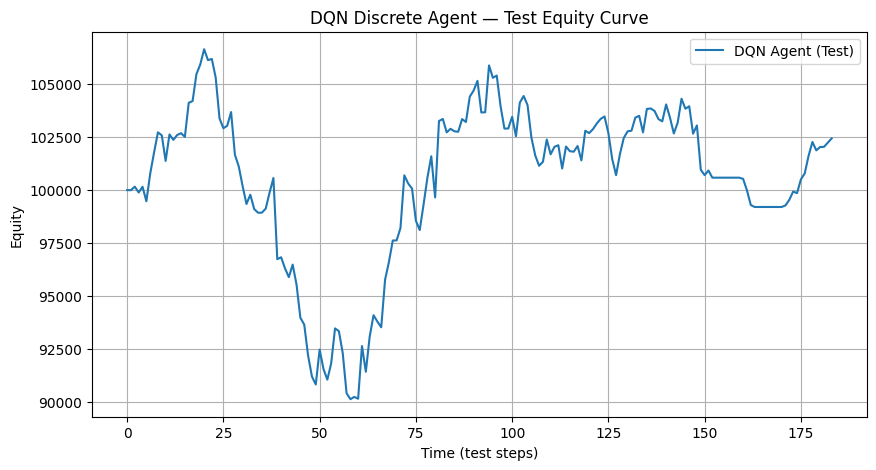

In [1]:
# Evaluate trained DQN on Test set 
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import DQN

import os, sys

# Setup Project Root
PROJECT_ROOT = r"E:/project"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# Now imports work
from envs.trading_env_discrete import TradingEnvDiscrete
from utils.metrics import equity_to_metrics



# ---------- Paths ----------
PROJECT_ROOT = r"E:/project"
DATA_PATH    = os.path.join(PROJECT_ROOT, "outputs", "datasets", "states_v1_single_asset.npz")
MODEL_PATH   = os.path.join(PROJECT_ROOT, "outputs", "models", "dqn_discrete", "dqn_final.zip")
EVAL_DIR     = os.path.join(PROJECT_ROOT, "outputs", "evaluations")
PLOTS_DIR    = os.path.join(PROJECT_ROOT, "outputs", "plots")

os.makedirs(EVAL_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

# ---------- Load dataset ----------
data = np.load(DATA_PATH)
X_train, X_val, X_test = data["X_train"], data["X_val"], data["X_test"]
prices_all = data["prices"]

start_test = len(X_train) + len(X_val)
prices_test = prices_all[start_test : start_test + len(X_test)]

# ---------- Load trained DQN ----------
model = DQN.load(MODEL_PATH)

# ---------- Run agent ----------
env = TradingEnvDiscrete(X_test, prices_test, reward_type="log_return")
obs, _ = env.reset()
done, truncated = False, False

equity_curve = []
actions = []
while not (done or truncated):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    equity_curve.append(env._get_portfolio_value())
    actions.append(action)

equity_curve = np.array(equity_curve, dtype=float)

# ---------- Save equity + actions ----------
dqn_equity_df = pd.DataFrame({
    "t": np.arange(len(equity_curve), dtype=int),
    "equity": equity_curve,
    "action": actions
})
dqn_csv = os.path.join(EVAL_DIR, "dqn_discrete_equity_test.csv")
dqn_equity_df.to_csv(dqn_csv, index=False)

# ---------- Metrics ----------
dqn_metrics = equity_to_metrics(equity_curve)
dqn_json = os.path.join(EVAL_DIR, "dqn_discrete_metrics_test.json")
with open(dqn_json, "w") as f:
    json.dump(dqn_metrics, f, indent=2)

# ---------- Plot ----------
plt.figure(figsize=(10,5))
plt.plot(dqn_equity_df["t"], dqn_equity_df["equity"], label="DQN Agent (Test)")
plt.xlabel("Time (test steps)")
plt.ylabel("Equity")
plt.title("DQN Discrete Agent — Test Equity Curve")
plt.legend()
plt.grid(True)
dqn_png = os.path.join(PLOTS_DIR, "dqn_discrete_equity_test.png")
plt.savefig(dqn_png, dpi=150, bbox_inches="tight")
# plt.close()

print("DQN Evaluation saved")
print("CSV:", dqn_csv)
print("JSON metrics:", dqn_json)
print("PNG plot:", dqn_png)
print("Metrics:", dqn_metrics)


In [2]:
# whenever you get error like ModuleNotFoundError: No module named 'envs' or 
# any other files class you are importing then you can replace this code with your original import code "sys.path"
# and then you can import that class from that perticular file 
# reason : sometimes jupyter can't location other directory files you need to mention exact path.
import os, sys

# Setup Project Root
PROJECT_ROOT = r"E:/project"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# Now imports work
from envs.trading_env_discrete import TradingEnvDiscrete
